# Bayes Theorem Problems

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np

from thinkbayes2 import Hist, Pmf, Cdf, Suite, Beta
import thinkplot

## The sock problem

Yuzhong Huang

There are two drawers of socks. The first drawer has 40 white socks and 10 black socks; the second drawer has 20 white socks and 30 black socks. We randomly get 2 socks from a drawer, and it turns out to be a pair(same color) but we don't know the color of these socks. What is the chance that we picked the first drawer.


In [2]:
# Solution

pmf = Pmf(['drawer 1', 'drawer 2'])
pmf['drawer 1'] *= (40/50)**2 + (10/50)**2
pmf['drawer 2'] *= (30/50)**2 + (20/50)**2
pmf.Normalize()
pmf.Print()

drawer 1 0.566666666667
drawer 2 0.433333333333


In [3]:
# Solution

pmf = Pmf(['drawer 1', 'drawer 2'])
pmf['drawer 1'] *= (40/50)*(39/49) + (10/50)*(9/49)
pmf['drawer 2'] *= (30/50)*(29/49) + (20/50)*(19/49)
pmf.Normalize()
pmf.Print()

drawer 1 0.568965517241
drawer 2 0.431034482759


In [4]:
# Solution

class Socks(Suite):
    
    def Likelihood(self, data, hypo):
        """Probability of data under hypo.
        
        data: 'pair' or 'no pair'
        hypo: tuple, number of (white, black) socks
        """
        white, black = hypo
        total = white + black
        like = white/total*(white-1)/(total-1) + black/total*(black-1)/(total-1)
        if data == 'pair':
            return like
        else:
            return 1-like                         

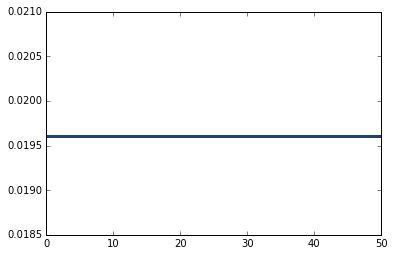

In [5]:
# Solution

n = 50
socks = Socks()
for white in range(n+1):
    socks[white, n-white] = 1
socks.Normalize()
thinkplot.Pdf(socks)

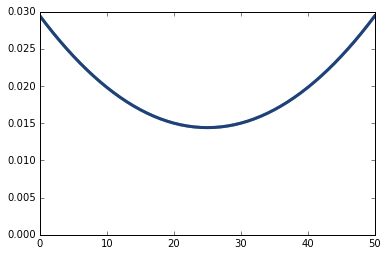

In [6]:
# Solution

socks.Update('pair')
thinkplot.Pdf(socks)
thinkplot.Config(ylim=[0,0.03])

## Chess-playing twins

Allen Downey

Two identical twins are members of my chess club, but they never show up on the same day; in fact, they strictly alternate the days they show up.  I can't tell them apart except that one is a better player than the other:  Avery beats me 60% of the time and I beat Blake 70% of the time.  If I play one twin on Monday and win, and the other twin on Tuesday and lose, which twin did I play on which day?

In [7]:
# Solution

pmf = Pmf(['AB', 'BA'])
pmf['AB'] = 0.4 * 0.3
pmf['BA'] = 0.7 * 0.6
pmf.Normalize()
pmf.Print()

AB 0.222222222222
BA 0.777777777778


In [8]:
# Solution

class Chess(Suite):
    
    prob_I_beat = dict(A=0.4, B=0.7)
    
    def Likelihood(self, data, hypo):
        """Probability of data under hypo.
        
        data: sequence of 'W' and 'L'
        hypo: sequence of 'A' and 'B'
        """
        total = 1
        for outcome, twin in zip(data, hypo):
            like = self.prob_I_beat[twin]
            if outcome == 'W':
                total *= like
            else:
                total *= 1-like
        return total

In [9]:
# Solution

chess = Chess(['AB', 'BA'])
chess.Update('WL')
chess.Print()

AB 0.222222222222
BA 0.777777777778


## 1984

by Katerina Zoltan

The place: Airstrip One. The reason: thoughtcrime. The time: ???

John's parents were taken by the Thought Police and erased from all records. John is being initiated into the Youth League and must pass a test. He is asked whether his parents are good comrades. It is not clear what John's admission officer knows:

1. He may know that John's parents have been erased and that John did not give them away.
2. He may know only that John's parents have been erased.
3. He may not know that John's parents have been erased.

It is a well known fact that children who have parents that are 'good comrades' have twice the chances of passing the test. However, if the admission officer knows that their parents committed thoughtcrime (but not that they have been erased yet), a child that gave his parents away has three times the chances of getting in than a child who did not give them away.

And if the admission officer knows the specifics of the arrest, a child that denies that the records are false and their parents existed has a 1/3 chance of getting in, while one who pretends that his parents never existed has a 2/3 chance. Lying to an admission officer that knows the parents have been erased will ensure that the child does not get in. Telling an admission officer that your parents do not exist when he does not know this will give you a 1/3 chance of getting in.

There is a 60% chance the admission officer knows nothing, a 25% chance that he knows the parents have been erased, and a 15% chance that the officer knows all of the details. John says that he never had parents and is admitted into the Youth League. What did his admission officer know?

In [10]:
# Solution

officer = {'everything':0.15, 'something':0.25, 'nothing':0.6}

class ThoughtPolice(Suite):

    def Likelihood(self, data, hypo):
        if data == 'gave away':
            if hypo == 'everything':
                return 0
            elif hypo == 'something':
                return 1
            else:
                return 3
        elif data == 'none':
            if hypo == 'everything':
                return 2
            elif hypo == 'something':
                return 1
            else:
                return 1
        else: # data == 'good comrades'
            if hypo == 'everything':
                return 0
            elif hypo == 'something':
                return 0
            else:
                return 2
        
pmf = ThoughtPolice(officer)
pmf.Print()

everything 0.15
nothing 0.6
something 0.25


In [11]:
# Solution

pmf.Update('none')
pmf.Print()

everything 0.260869565217
nothing 0.521739130435
something 0.217391304348


### Where Am I? - The Robot Localization Problem

by Kathryn Hite

Bayes's Theorem proves to be extremely useful when building mobile robots that need to know where they are within an environment at any given time.  Because of the error in motion and sensor systems, a robot's knowledge of its location in the world is based on probabilities.  Let's look at a simplified example that could feasibly be scaled up to create a working localization model.

**Part A:**  We have a robot that exists within a very simple environement.  The map for this environment is a row of 6 grid cells that are colored either green or red and each labeled $x_1$, $x_2$, etc.  In real life, a larger form of this grid environment could make up what is known as an occupancy grid, or a map of the world with places that the robot can go represented as green cells and obstacles as red cells.

|G|R|R|G|G|G|
|-|-|-|-|-|-|
|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|$x_6$|

The robot has a sensor that can detect color with an 80% chance of being accurate.

Given that the robot gets dropped in the environment and senses **red**, what is the probability of it being in each of the six locations?

In [12]:
# Solution

colors = 'GRRGGG'
locs = range(len(colors))
data = 'R'

pmf = Pmf(locs)
for hypo in pmf:
    if colors[hypo] == data:
        pmf[hypo] *= 0.8
    else:
        pmf[hypo] *= 0.2
pmf.Normalize()
pmf.Print()

0 0.0833333333333
1 0.333333333333
2 0.333333333333
3 0.0833333333333
4 0.0833333333333
5 0.0833333333333


In [13]:
# Solution

class Robot(Suite):
    
    colors = 'GRRGGG'
    
    def Likelihood(self, data, hypo):
        """
        
        data: 'R' or 'G'
        hypo: index of starting location
        """
        if self.colors[hypo] == data:
            return 0.8
        else:
            return 0.2

In [14]:
# Solution

robot = Robot(locs)
robot.Update('R')
robot.Print()

0 0.0833333333333
1 0.333333333333
2 0.333333333333
3 0.0833333333333
4 0.0833333333333
5 0.0833333333333


**Part B:** This becomes an extremely useful tool as we begin to move around the map.  Let's try to get a more accurate knowledge of where the robot falls in the world by telling it to move forward one cell.

The robot moves forward one cell from its previous position and the sensor reads **green**, again with an 80% accuracy rate.  Update the probability of the robot having started in each location.

In [15]:
# Solution

class Robot2(Suite):
    
    colors = 'GRRGGG'
    
    def Likelihood(self, data, hypo):
        """
        
        data: tuple (offset, 'R' or 'G')
        hypo: index of starting location
        """
        offset, color = data
        index = (hypo + offset) % len(self.colors)
        if self.colors[index] == color:
            return 0.8
        else:
            return 0.2

In [16]:
# Solution

robot = Robot2(locs)
robot.Update((0, 'R'))
robot.Print()

0 0.0833333333333
1 0.333333333333
2 0.333333333333
3 0.0833333333333
4 0.0833333333333
5 0.0833333333333


In [17]:
# Solution

robot.Update((1, 'G'))
robot.Print()

0 0.030303030303
1 0.121212121212
2 0.484848484848
3 0.121212121212
4 0.121212121212
5 0.121212121212


## Red Dice problems

Suppose I have a six-sided die that is red on 2 sides and blue on 4 sides, and another die that's the other way around, red on 4 sides and blue on 2.

I choose a die at random and roll it, and I tell you it came up red.  What is the probability that I rolled the second die (red on 4 sides)?

In [18]:
# Solution

from fractions import Fraction

d1 = Pmf({'Red':Fraction(2), 'Blue':Fraction(4)}, label='d1 (bluish) ')
d1.Print()

Blue 2/3
Red 1/3


In [19]:
# Solution

d2 = Pmf({'Red':Fraction(4), 'Blue':Fraction(2)}, label='d2 (reddish)')
d2.Print()

Blue 1/3
Red 2/3


In [20]:
# Solution

dice = Pmf({d1:Fraction(1), d2:Fraction(1)})
dice.Print()

d2 (reddish) 1/2
d1 (bluish)  1/2


In [21]:
# Solution

class Dice(Suite):
    def Likelihood(self, data, hypo):
        """
        data: 'Red' or 'Blue'
        hypo: a Die object
        """
        return hypo[data]

In [22]:
# Solution

prior = Dice({d1:Fraction(1), d2:Fraction(1)})
prior.Print()

d2 (reddish) 1/2
d1 (bluish)  1/2


In [23]:
# Solution

posterior = prior.Copy()
posterior.Update('Red')
posterior.Print()

d2 (reddish) 2/3
d1 (bluish)  1/3


## Scenario B

Suppose I roll the same die again.  What is the probability I get red?

In [24]:
# Solution

from thinkbayes2 import MakeMixture

predictive = MakeMixture(posterior)
predictive.Print()

Blue 4/9
Red 5/9


## Scenario A

Instead of rolling the same die, suppose I choosing a die at random and roll it.  What is the probability that I get red?

In [25]:
# Solution

from thinkbayes2 import MakeMixture

predictive = MakeMixture(prior)
predictive.Print()

Blue 1/2
Red 1/2


## Scenario C

Now let's run a different experiment.  Suppose I choose a die and roll it.  If the outcome is red, I report the outcome.  Otherwise I choose a die again and roll again, and repeat until I get red.

What is the probability that the last die I rolled is the reddish one?

In [26]:
# Solution

# On each roll, there are four possible results, with these probabilities:

#    d1, red       1/2 * 1/3
#    d1, blue      1/2 * 2/3
#    d2, red       1/2 * 2/3
#    d2, blue      1/2 * 1/3

#On the last roll, I tell you that the outcome is red, so we are left with two possibilities:

#    d1, red       1/2 * 1/3
#    d2, red       1/2 * 2/3

# The likelihood ratio is 2 to 1, so we can use that to update the prior:

In [27]:
# Solution

posterior = prior.Copy()
posterior[d1] *= 1
posterior[d2] *= 2
posterior.Normalize()
posterior.Print()

d2 (reddish) 2/3
d1 (bluish)  1/3


## Scenario D

Finally, suppose I choose a die and roll it over and over until I get red, then report the outcome.  What is the probability that the die I rolled is the reddish one?

In [28]:
# Solution

# In this case, the likelihood of the data is the same regardless of
# which die I rolled, so the posterior is the same as the prior.

posterior = prior.Copy()
posterior.Print()

d2 (reddish) 1/2
d1 (bluish)  1/2


In [29]:
# Solution

#In summary, each of the four scenarios yields a different pair of posterior
# and predictive distributions.

# Scenario        Posterior probability of d2      Predictive probability of red
# A               2/3                              1/2
# B               2/3                              5/9
# C               2/3                              1
# D               1/2                              1

## The bus problem

Allen Downey

Two buses routes run past my house, headed for Arlington and Billerica.  In theory, the Arlington bus runs every 20 minutes and the Billerica bus every 30 minutes, but by the time they get to me, the time between buses is well-modeled by exponential distributions with means 20 and 30.

Part 1: Suppose I see a bus outside my house, but I can't read the destination.  What is the probability that it is an Arlington bus?

Part 2: Suppose I see a bus go by, but I don't see the destination, and 3 minutes later I see another bus.  What is the probability that the second bus is going to Arlington?

In [30]:
# Solution

def generate_times(lam, n=10):
    gaps = np.random.exponential(lam, n)
    times = np.cumsum(gaps)
    for time in times:
        yield time

In [31]:
# Solution

for time in generate_times(20, 10):
    print(time)

15.1381021981
35.6595368992
40.2555876685
44.5338062274
58.7218133396
82.9148030062
113.755194822
126.646534094
138.89916925
145.582801415


In [32]:
# Solution

def generate_buses(names, lams, n):
    buses = [generate_times(lam, n) for lam in lams]
    times = [next(bus) for bus in buses]

    while True:
        i = np.argmin(times) 
        yield(names[i], times[i])
        times[i] = next(buses[i])

In [33]:
# Solution

next(generate_buses('AB', [20, 30], 10))

('A', 27.901039669324383)

In [34]:
# Solution

res = []
for bus, time in generate_buses('AB', [20, 30], 1000):
    res.append((bus, time))

In [35]:
# Solution

buses, times = zip(*res)

In [36]:
# Solution

hist = Hist(buses)
hist['A'] / hist.Total()

0.6045949214026602